**Author**: J W Debelius<br/>
**Date**: 17 August 2015<br/>
**virtualenv**: power play

In [1]:
%%javascript
IPython.load_extensions('calico-spell-check', 'calico-document-tools')

<IPython.core.display.Javascript object>

# Number of iterations

The purpose of this notebook is to simulate the number of iterations required to collapase power onto a central limit theorm by varying two parameters, `num_runs` and `num_iter`. The `num_iter` refers to the number of tests performed, and then combined to calculate the power. The `num_runs` determines how many of these emperical power values are averaged for the effect size calculation.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import skbio
import scipy
import skbio

import absloute_power.utils as ap

from matplotlib import rcParams
from skbio.stats.power import subsample_power
import absloute_power.utils as ap

from statsmodels.stats.power import FTestAnovaPower

ft = FTestAnovaPower()

We'll also set it up so that anything that is plotted here is plotted using Helvetica.

In [3]:
# Sets up plotting parameters so that the default setting is use to Helvetica
# in plots
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica', 'Arial']
rcParams['text.usetex'] = True


We'll also set a random seed, so that hte values that come out are consistent.

In [11]:
np.random.seed(30)

We'll start by simulating a pair of distributions which we can test with a two-sample t test.

In [54]:
# Defines the test
def practice_test(samples):
    return scipy.stats.ttest_ind(samples[0], samples[1])[1]

# Defines the sample
sample1 = np.random.randn(1000) * 3 + 2
sample2 = np.random.randn(1000) * 3 + 0.5

# Tests the over all distributions
practice_test([sample1, sample2])

2.9133447473274571e-24

Let's vary the number of samples that we iterate over, between 10 and 5000 tests per iteration. We'll do 100 runs, and use that to calculate the power.

In [55]:
num_iter = [10, 50, 100, 500, 1000, 5000]
num_runs = 100
power = []

for ni in num_iter:
    power.append(
        subsample_power(practice_test,
                        [sample1, sample2],
                        min_counts=10,
                        max_counts=40,
                        counts_interval=10,
                        num_runs=num_runs,
                        num_iter=ni)
    )
    print ni

10
50
100
500
1000
5000


Now, let's convert the power to effect size, using statsmodels. This is what we typically use when the data is underpowered.

In [56]:
help(ap.extrapolate_f)

Help on function extrapolate_f in module absloute_power.utils:

extrapolate_f(counts, pwr_, cnts, alpha=0.05)
    Converts emperical power to extrapolated
    
    Parameters
    ----------
    counts : array
        The number of observations which should be used in the final power
        result.
    pwr_ : array
        The observed power. Each column corresponds to the number of
        observations used in `cnts`. The rows correspond to different runs
    cnts : array
        The number of observations drawn to calculate the observed power.
    alpha : float, optional
        The critical value for power calculations.
    
    Returns
    -------
    power : array
        The extrapolated power for the number of observations given by `counts`



In [74]:
len(power)

6

In [75]:
z_effs = []
for j, (pwr, cnt) in enumerate(power):
    print j
    z_eff = []
    for i, r in enumerate(pwr):
        try:
            z_eff.append((ap.z_effect(counts=cnt, power=r)))
        except:
            z_eff.append(np.array([1, 1, 1])*np.nan)
        z_effs.append(z_eff)
    

0
1
2
3
4
5


Finally, we're going to put together a set of plots. We'll define a set of helper functions to let us manipulate the effect size results, and then to plot them.

We'll also define parameters for plotting the data. We'll plot 100 iterations for each set, with values betwen 2 and 100. The critical value is 0.05. We'll combined data for 1, 3, 5, 10, and 25 sets of runs.

In [67]:
counts = np.hstack((np.array([2]),
                    np.arange(5, 101, 7.5)))
runs = 100
alpha = 0.05
fs=10

num_draws = [(1, all_e), 
             (3, lambda x: calc_e(x, 3, runs)),
             (5, lambda x: calc_e(x, 5, runs)),
             (10, lambda x: calc_e(x, 10, runs)),
             (25, lambda x: calc_e(x, 25, runs)),
            ]

In [64]:
color1 = np.array([0.45, 0.45, 0.45])
def all_e(eff):
    """Gets all the effect size values"""
    flat = np.hstack(eff)
    return flat[np.isnan(flat) == False]

def calc_e(eff, num_draws=3, runs=25):
    """..."""
    flat = np.array([
        np.nanmean(np.random.choice(np.hstack(eff), num_draws))
        for i in xrange(runs)
        ])
    return flat[np.isnan(flat) == False]

def plot_e(ax, eff, counts, pwr_alpha=0.05, color=color1, opac=0.1):
    ax.plot(counts,
            ap.z_power(eff, counts, alpha=pwr_alpha), 
            '-',
            color=color,
            alpha=opac)

def plot_mean(ax, eff, counts):
    ax.plot(counts, ap.z_power(np.nanmean(eff), counts, 0.05), 'r-')

Finally, we'll plot the data.

In [65]:
help(ap.z_power)

Help on function z_power in module absloute_power.utils:

z_power(counts, eff, alpha=0.05)
    Estimates power for a z distribution from an effect size
    
    This is based on the equations in
        Lui, X.S. (2014) *Statistical power analysis for the social and
        behavioral sciences: basic and advanced techniques.* New York:
        Routledge. 378 pg.
    The equation assumes a positive magnitude to the effect size and a
    two-tailed test.
    
    Parameters
    ----------
    counts : array
        The number of observations for each power depth
    effect : float
        A standard measure of the difference between the underlying populations
     alpha : float
        The critial value used to calculate the power
    
    Returns
    power : array
        The statistical power at the depth specified by `counts`



ValueError: num must be 0 <= num <= 36, not 37

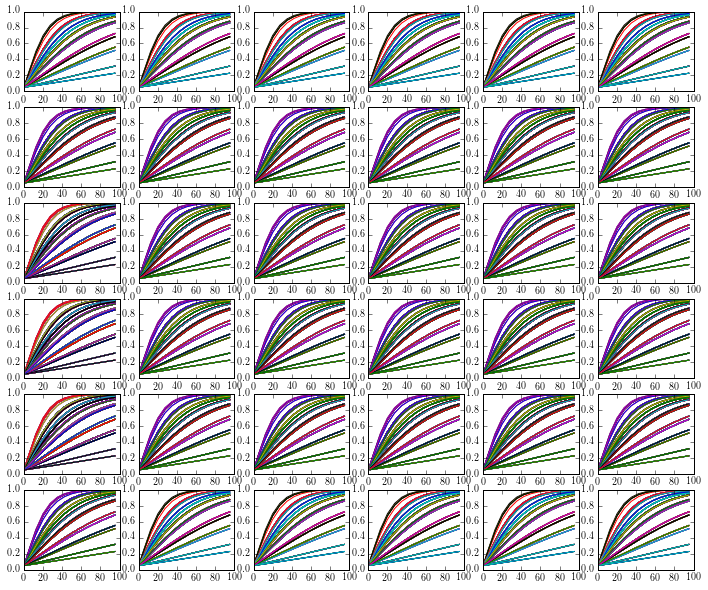

In [73]:
mean_eff = np.zeros((len(num_iter), len(num_draws)))
stdv_eff = np.zeros((len(num_iter), len(num_draws)))

fig1 = plt.figure()

fig1.set_size_inches((12, 10))

for idy, eff in enumerate(z_effs):
    for idx, (num_draw, f_) in enumerate(num_draws):
        ax1 = fig1.add_subplot(6, 6, idx * 6 + idy + 1)

IndexError: list index out of range

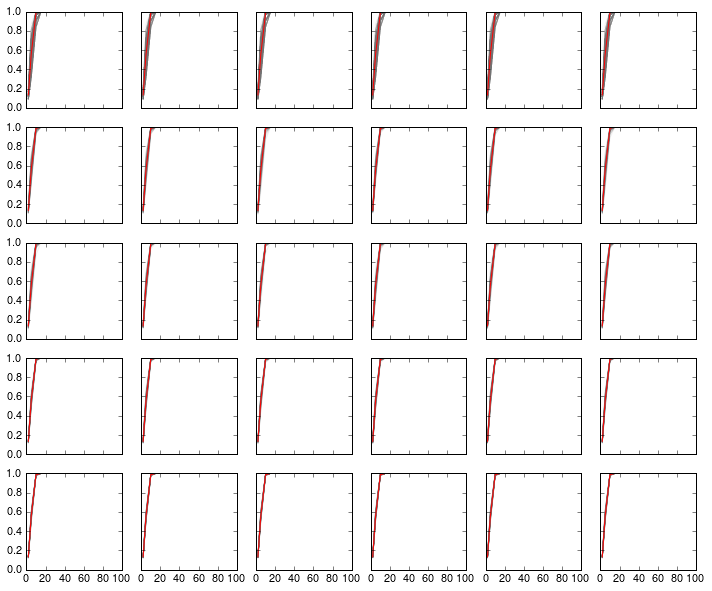

In [47]:
% matplotlib inline
mean_eff = np.zeros((len(num_iter), len(num_draws)))
std_eff = np.zeros((len(num_iter), len(num_draws)))

fig1 = plt.figure()
fig1.set_size_inches((12, 10))

for idy, eff in enumerate(z_effs):
    for idx, (num_draw, f_) in enumerate(num_draws):
        eff = np.hstack(eff)
        
#         fn = '/Users/jwdebelius/Desktop/power_figs/iter/images/%i_runs_%i_iter.pdf' % (num_draw, num_iter[idy])
        
        ef2 = f_(eff)
        
        mean_eff[idy, idx] = ef2.mean()
        std_eff[idy, idx] = ef2.std()
        # Creates the summary figure for the notebook
        ax1 = fig1.add_subplot(5, 6, idx * 6 + idy + 1)
        for e in ef2:
            plot_e(ax1, e, counts, alpha, opac=0.1)
        plot_mean(ax1, eff, counts)
        # Cleans up the axis
        ap.format_ax(ax1,
                     xlim=[0, 100], 
                     ylim=[0, 1], 
                     show_x=(idx==4),
                     show_y=(idy==0),
                     xticks=np.arange(0, 101, 20),
                     )

The data starts to collapse with 1000 samples at 5 points, or 500 iterations at 10 points. So, 5000 seems like the magic number of iterations with this data.

In [25]:
print mean_eff


[[ 0.29926626  0.30547531  0.3052029   0.30133185  0.30214643]
 [ 0.22158553  0.2243332   0.22722672  0.22178338  0.22274863]
 [ 0.21915333  0.21873909  0.21966436  0.22266008  0.22089997]
 [ 0.22416815  0.22245122  0.2240486   0.22386182  0.22426795]
 [ 0.22371977  0.22462747  0.22457484  0.22351283  0.22381225]
 [ 0.22554615  0.22543304  0.2266719   0.22515923  0.22559694]]


In [26]:
print std_eff

[[ 0.11441656  0.07163085  0.04532036  0.03211641  0.02152529]
 [ 0.08180874  0.04977255  0.03488494  0.02656935  0.01601765]
 [ 0.05962898  0.03042859  0.02787322  0.01731821  0.01264535]
 [ 0.02619813  0.01656193  0.011507    0.00667365  0.00475571]
 [ 0.02029435  0.0119745   0.00899817  0.00723853  0.00348579]
 [ 0.01213517  0.00633409  0.00489351  0.00350782  0.00215695]]


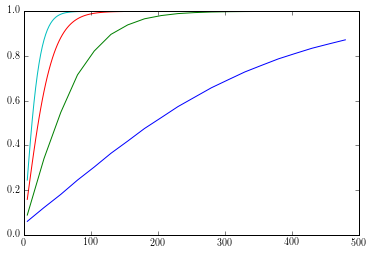

In [36]:
plt.plot(np.arange(5, 500, 25), ap.z_power(np.arange(5, 500, 25), 0.2), 'b')
plt.plot(np.arange(5, 500, 25), ap.z_power(np.arange(5, 500, 25), 0.4), 'g')
plt.plot(np.arange(5, 150, 2.5), ap.z_power(np.arange(5, 150, 2.5), 0.6), 'r')
plt.plot(np.arange(5, 150, 2.5), ap.z_power(np.arange(5, 150, 2.5), 0.8), 'c')